# INHA_CO2_GEOSTATS Demo

![LabLogo](./LabLogoSAL.svg?raw=true)

This demo showcases an implementation of basic geostatistical modelling, including sequential Gaussian simulation (**SGS**), sequential indicator simulation (**SIS**), and multi-point statistics (**MPS**). In this demo, we first import 2D well information with various reservoir properties, such as porosity, acoustic impedence, facies, permeability and brittleness. Then we calculate variogram to assess spatial continuity in the reservoir. Finally, with the designed variogram, we run SGS with (1) Python, which will be readily too heave as dimension rises, and (2) GSLIB, programed in Fortran by Dr. Clayton Deuatsch.:

1. Load open packages and import the CSV file (regarding well data) into Python using Pandas.
2. Visualize the well data.
3. Compute variogram.
4. **Implement SGS using Python**
5. **Repeat SGS with GSLIB**
5. **run SIS (for categorical facies) with GSLIB**

The demo is presented by SAL at Inha University. You can reach out through [WebSite](https://geomodeller.github.io/) | [GitHub/petroinha](https://github.com/petroinha) 

**Note that this workflow was originally developed by Dr. Pyrcz, and the details can be found from the https://github.com/GeostatsGuy/GeostatsPy **


### 1. Load open packages and import the CSV file

In [6]:
%reload_ext autoreload
%autoreload 2

## Import packages that will be used in this demo
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

from main import Gen_TwoGeoStats 

In [25]:
gen_real = Gen_TwoGeoStats()
gen_real.load_well_data(pd.read_csv('1_sample_data.csv'))
gen_real.data['NPor'], tvPor, tnsPor = geostats.nscore(gen_real.data, 'Porosity') # nscore transform for all facies porosity
gen_real.data.describe()                                               # summary statistics 

,X,Y,Z,Facies,Porosity,Perm,AI,NPor
count,271.000000,271.000000,271.0,271.000000,271.000000,271.000000,271.000000,2.710000e+02
mean,479.501845,526.092251,1000.0,0.771218,0.141707,405.800235,5174.470023,-8.247556e-03
std,286.991468,283.632200,0.0,0.420826,0.028341,2187.349333,1136.028676,1.034814e+00
min,0.000000,9.000000,1000.0,0.000000,0.060693,0.018054,1808.774980,-5.257167e+00
25%,240.000000,299.000000,1000.0,1.000000,0.121702,1.583239,4481.353010,-6.716008e-01
50%,480.000000,519.000000,1000.0,1.000000,0.139365,7.817239,5111.164955,1.490050e-08
75%,710.000000,760.000000,1000.0,1.000000,0.157774,52.040563,5956.595129,6.716008e-01
max,990.000000,1014.000000,1000.0,1.000000,0.221607,24182.542970,8260.108949,2.903511e+00


### 2. Visualize the well data.

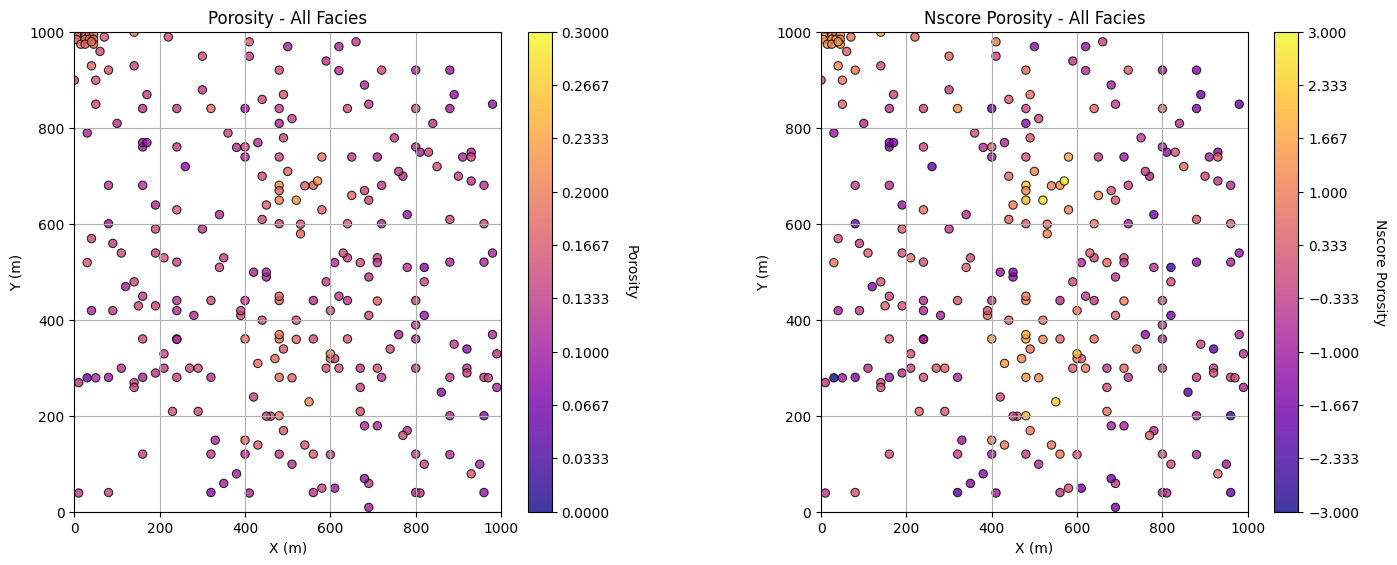

In [26]:
cmap = plt.cm.plasma #color map

## Visualize porosity Map
plt.figure()
plt.subplot(121)
GSLIB.locmap_st(gen_real.data,'X','Y','Porosity',0,1000,0,1000,0,0.3,'Porosity - All Facies','X (m)','Y (m)','Porosity',cmap)
plt.grid()
plt.subplot(122)
GSLIB.locmap_st(gen_real.data,'X','Y','NPor',0,1000,0,1000,-3,3,'Nscore Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)
plt.grid()
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1, wspace=0.4, hspace=0.3)
plt.show()

### 3. Calulate variogram 

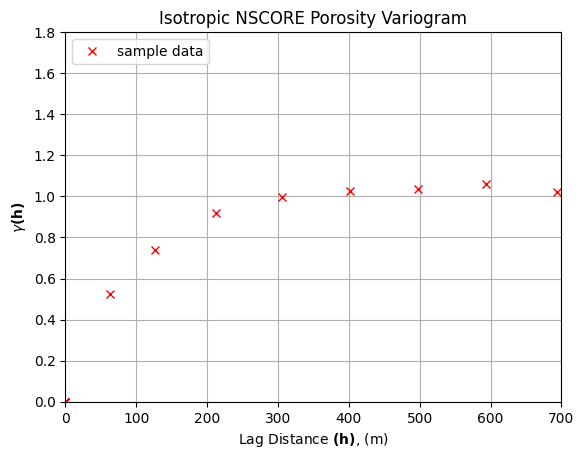

In [28]:
## Calculate Sample Data Isotropic Variograms
## These are variogram parameters, please refer to the reference books
tmin = -9999.; tmax = 9999.; 
lag_dist = 100.0; lag_tol = 100.0; nlag = 30; bandh = 9999.9; azi = 0; atol = 90.0; isill = 1

lag, por_gamma, por_npair = geostats.gamv(gen_real.data,"X","Y","NPor",tmin,tmax,lag_dist,lag_tol,nlag,azi,atol,bandh,isill)
plt.figure()
plt.plot(lag,por_gamma,'x',color='red',label='sample data')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Isotropic NSCORE Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.legend(loc='upper left')
plt.grid(True)


 x,y,z offsets = 0.0,10.0


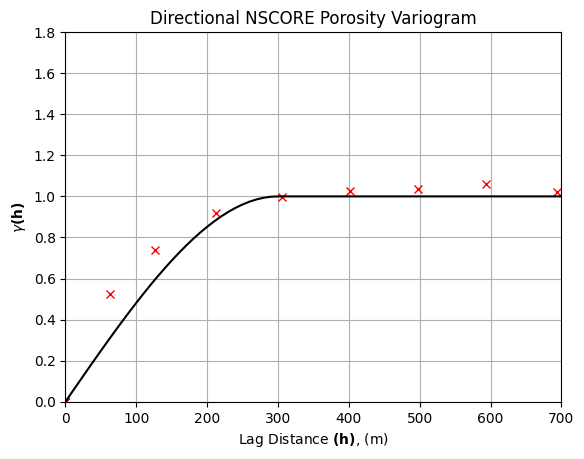

In [29]:
## Fit the above figure to a variogram model
nug = 0.0; # No nugget
nst = 1;   # 1 nest structure variogram model parameters                                       
it1 = 1;   # type 1 = Gaussian, 2 = Spherical, 3 = exponential
cc1 = 1.0; # sill
azi1 = 0;  # No need for isotropic variogram
hmaj1 = 300; hmin1 = 300 # Range

vario = GSLIB.make_variogram(nug,nst,it1,cc1,azi1,hmaj1,hmin1) # make model object
nlag = 70; xlag = 10; azm = 0;                                # project the model in the 0 azimuth (doesn't matter since I assume isotropic)
index45,h45,gam45,cov45,ro45 = geostats.vmodel(nlag,xlag,azm,vario)

plt.plot(lag,por_gamma,'x',color = 'red')
plt.plot(h45,gam45,color = 'black')
plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
plt.ylabel(r'$\gamma \bf(h)$')
plt.title('Directional NSCORE Porosity Variogram')
plt.xlim([0,700])
plt.ylim([0,1.8])
plt.grid()

## 4. Run Sequential Gaussian simulation in Python (slow) 



 Data for SGSIM: Number of acceptable data     = 45
                 Number trimmed                = 0
                 Weighted Average              = 0.1387
                 Weighted Variance             = 0.0009
                 Weighted Transformed Average  = 0.0038
                 Weighted Transformed Variance = 0.9838
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 250
   currently on node 500
   currently on node 750
   currently on node 1000
   currently on node 1250
   currently on node 1500
   currently on node 1750
   currently on node 2000
   currently on node 2250
Reassigning data to nodes

 Realization 0: number   = 2500
                                   mean     = 0.0767 (close to 0.0?)
                                   variance = 0.6712 (close to gammabar(V,V)? approx. 1.0)


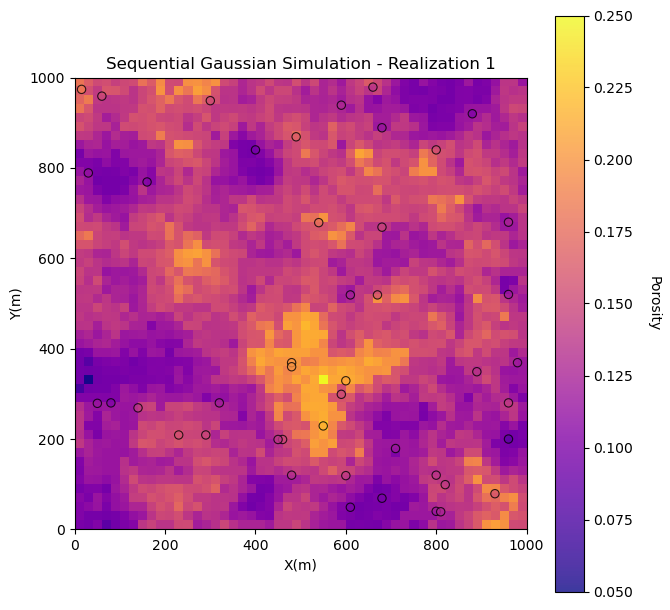

CPU times: total: 3min 52s
Wall time: 14.1 s


In [7]:
%%time

## Demonstration of Multiple Realizations - Short Continuity(100)
nx = 50; ny = 50; #number of cells
xsiz = 20.0; ysiz = 20.0; #cell size
xmn = 10.0; ymn = 10.0; # grid origin, location center of lower left cell

## basic indicator kriging parameters
nxdis = 1; nydis = 1   # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 20; # minimum and maximum data for kriging 
radius = 400;          # maximum search distance
ktype = 1;             # kriging type, 0 - simple, 1 - ordinary
skmean = 0             # desired mean (after Normal score transform, should be zero)
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=300,hmin1=300)
tmin = -999; tmax = 999  # data trimming limits

sim = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,twtcol=0,
            zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=ktype,colocorr=0.0,sec_map=0,vario=vario)
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; 

cmap = plt.cm.plasma #color map
plt.subplot(131)
GSLIB.locpix_st(sim,xmin,xmax,ymin,ymax,xsiz,0.05,0.25,df,'X','Y','Porosity','Sequential Gaussian Simulation - Realization 1','X(m)','Y(m)','Porosity',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

I hope you find this code and demonstration useful. I'm always happy to discuss any question you may find,

*Honggeun (honggeun.jo@inha.ac.kr)* 

**Honggeun Jo**, Ph.D., P.Eng. Assistant Professor The Department of Energy Resources Engineering, Inha University (Korea).
